# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import logging
import itertools
from tqdm.notebook import tqdm
import warnings

from sklearn.impute import SimpleImputer

warnings.filterwarnings('ignore', message='use_inf_as_na option is deprecated')
# Suppress prophet logging messages
logger = logging.getLogger('prophet')
logger.setLevel(logging.CRITICAL)

In [10]:
basisAnalytik = pd.read_csv('BasisAnalytikInterpolated.csv', encoding='utf-8')
meteorological = pd.read_csv('MeteorologicalFiltered.csv', encoding='utf-8')

basisAnalytik['Date'] = pd.to_datetime(basisAnalytik['Date'], format='%Y-%m-%d')
meteorological['Date'] = pd.to_datetime(meteorological['Date'], format='%Y-%m-%d')

# Functions

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Analysis

## Water Temparature

In [16]:
meteorological_water_temp = meteorological
meteorological_water_temp['y'] = basisAnalytik['Wassertemp.(vor_Ort)_°C']
meteorological_water_temp = meteorological_water_temp.rename(columns={'Date': 'ds'})

### Feature Importance

C:\Users\david\AppData\Local\Temp\ipykernel_19652\3039388523.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


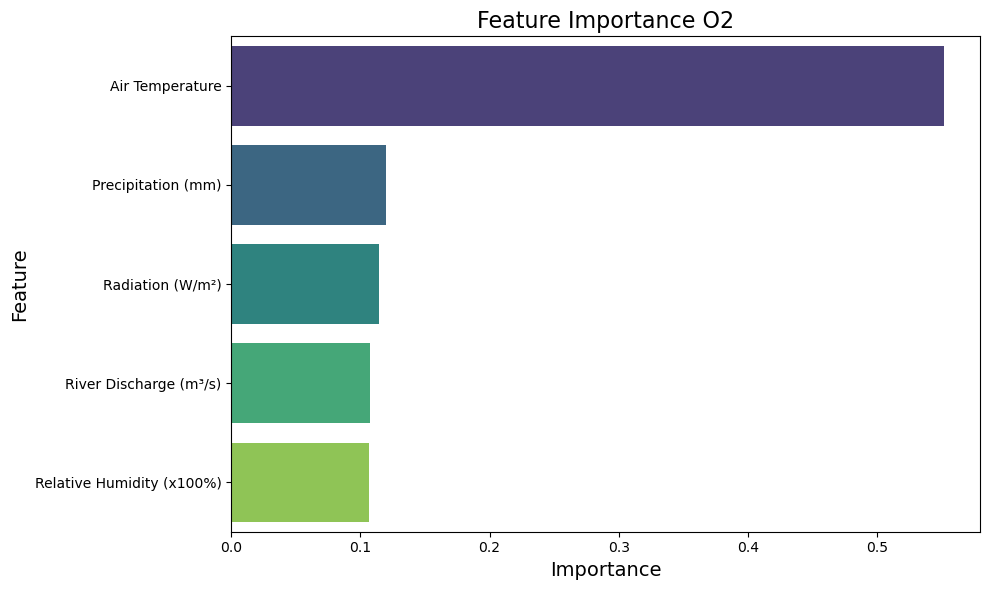

In [17]:
X = meteorological_water_temp.iloc[:, 1:6]
y = meteorological_water_temp["y"]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance Water Temperature', fontsize=16)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('feature_importance.png', dpi=300)

# Display the plot
plt.show()

### Baseline 

In [25]:
cutoff_date = '2009-01-15'

# Splitting the dataset based on the cutoff date
train_water_temp_baseline = meteorological_water_temp[meteorological_water_temp['ds'] < cutoff_date].copy()
test_water_temp_baseline = meteorological_water_temp[meteorological_water_temp['ds'] >= cutoff_date].copy()

# Creating a time index for both training and testing sets
train_water_temp_baseline.loc[:, 'time_index'] = range(len(train_water_temp_baseline))
test_water_temp_baseline.loc[:, 'time_index'] = range(len(train_water_temp_baseline), len(train_water_temp_baseline) + len(test_water_temp_baseline))

# Define the features for the model
features = ['time_index', 'Air Temperature', 'Relative Humidity (x100%)', 'Precipitation (mm)', 'Radiation (W/m²)', 'River Discharge (m³/s)']
X_train = train_water_temp_baseline[features]
y_train = train_water_temp_baseline['y']

X_test = test_water_temp_baseline[features]
y_test = test_water_temp_baseline['y']

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

predictions = linear_model.predict(X_test)

### Facebook Prophet Model

* Time features such as trend and seasonality are created natively in this model (does not require stationary time series). Handles rolling means, lags, and other features.
* Seasonality components, such as daily and yearly, are estimated with Fourier series (allows to decompose complex periodic signals into simpler components, making it easier to analyze and understand the underlying patterns and characteristics of the time series data).
* You can add extra-regressors (continous or categorical). Tends to give better results then tree-based models.
* Very fast training time.

#### Train/Test Split

In [29]:
cutoff_date = '2009-01-15'

train_water_temp = meteorological_water_temp[meteorological_water_temp['ds'] < cutoff_date]
test_water_temp = meteorological_water_temp[meteorological_water_temp['ds'] >= cutoff_date]
train_water_temp.reset_index(drop=True, inplace=True)
test_water_temp.reset_index(drop=True, inplace=True)
test_water_temp_noY = test_water_temp.drop(columns=['y'])

#### Hyperparameter Tuning

In [41]:
# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.05, 0.01, 0.1, 0.5],  # Controls the model's flexibility
    'seasonality_prior_scale': [10.0, 15.0, 20.0, 10.0],  # Controls the model's flexibility for yearly seasonality
    'seasonality_mode': ['additive', 'multiplicative'],  # Determines how seasonality affects the trend
}

# Generate all combinations of parameters for the grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in tqdm(all_params, desc="Hyperparameter Tuning"):
    m = Prophet(**params)
    m.add_regressor('Air Temperature', standardize=False)
    m.add_regressor('Relative Humidity (x100%)', standardize=False)
    m.add_regressor('Precipitation (mm)', standardize=False)
    m.add_regressor('Radiation (W/m²)', standardize=False)
    m.add_regressor('River Discharge (m³/s)', standardize=False)
    
    m.fit(train_water_temp) 
    
    # 'initial': Use the first 20 years of data for training to capture long-term trends and seasonal patterns
    # 'period': Advance one year at each cross-validation step to gradually test the model on newer data
    # 'horizon': Forecast one year into the future
    initial = (train_water_temp.shape[0]-12)*30
    df_cv = cross_validation(m, initial=f'{str(initial)} days', period='365 days', horizon='365 days', parallel='processes')
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0]) 

best_params_idx = np.argmin(rmses)
best_params = all_params[best_params_idx]

# Output the best parameters found during tuning
print("Best Parameters Found:", best_params)

Hyperparameter Tuning:   0%|          | 0/32 [00:00<?, ?it/s]

13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:26:00 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing
13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing
13:26:07 - cmdstanpy - INFO - Chain [1] start processing
13:26:07 - cmdstanpy - INFO - Chain [1] done processing
13:26:09 - cmdstanpy - INFO - Chain [1] start processing
13:26:09 - cmdstanpy - INFO - Chain [1]

Best Parameters Found: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


#### Train with Best Parameters

In [42]:
# Train final model with the best parameters

final_model = Prophet(interval_width=0.95, **best_params)
final_model.add_regressor('Air Temperature', standardize=False)
final_model.add_regressor('Relative Humidity (x100%)', standardize=False)
final_model.add_regressor('Precipitation (mm)', standardize=False)
final_model.add_regressor('Radiation (W/m²)', standardize=False)
final_model.add_regressor('River Discharge (m³/s)', standardize=False)

final_model.fit(train_water_temp)

13:27:57 - cmdstanpy - INFO - Chain [1] start processing
13:27:57 - cmdstanpy - INFO - Chain [1] done processing


#### Test/Predict Final Year

In [43]:
forecast_water_temp = final_model.predict(test_water_temp_noY)

In [44]:
columns_1 = ['ds', 'y']
columns_2 = ['yhat']

data = {
    'Date': test_water_temp['ds'],
    'Water Temperature': test_water_temp['y'],
    'Predictions FbProphet': forecast_water_temp['yhat'],
    'Predictions Baseline': predictions
}
water_temp_predictions = pd.DataFrame(data)

### Visualize Forecast

C:\Users\david\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\david\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


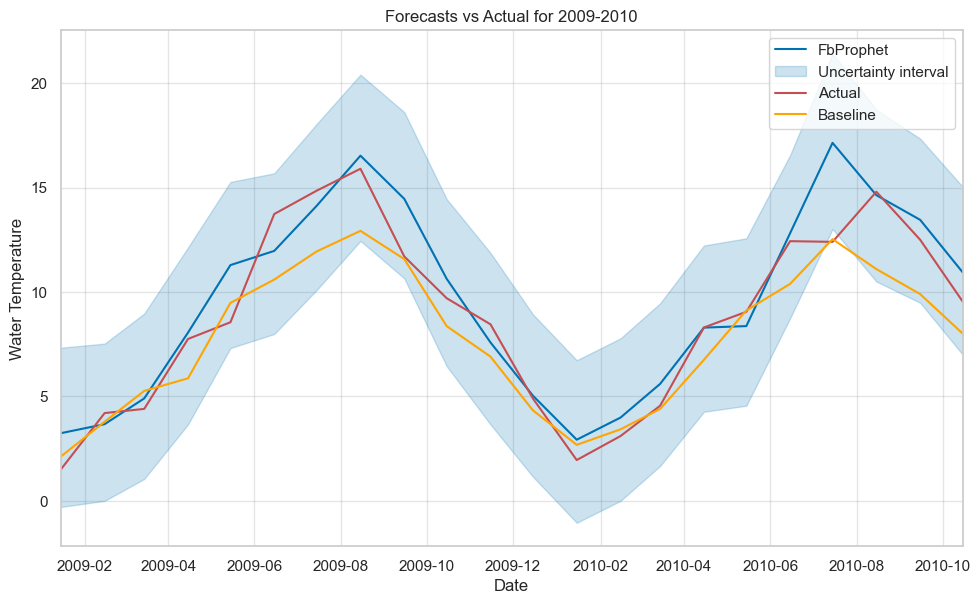

In [45]:
# Generate the forecast plot
fig = final_model.plot(forecast_water_temp)
ax = fig.gca()  # Get current axis

# Overlay actual values
ax.plot(water_temp_predictions['Date'], water_temp_predictions['Water Temperature'], color='r', label='Actual', linewidth=1.5)

# Overlay baseline values
ax.plot(water_temp_predictions['Date'], water_temp_predictions['Predictions Baseline'], color='orange', label='Baseline', linewidth=1.5)

# Adjust x-axis to focus on a specific year
ax.set_xlim(water_temp_predictions['Date'].min(), water_temp_predictions['Date'].max())

# Enhance the plot
ax.set_title('Forecasts vs Actual for 2009-2010')
ax.set_xlabel('Date')
ax.set_ylabel('Water Temperature')

# Update legend, manually specify handles and labels to control entries
handles, labels = ax.get_legend_handles_labels()

# Remove unwanted label (assuming it's the first one automatically added by Prophet)
# and add custom label for Prophet predictions if not correctly labeled
# The following step assumes that the unwanted label is first, and the FbProphet is second
new_labels = ['FbProphet', 'Uncertainty interval', 'Actual', 'Baseline']
ax.legend(handles=handles[1:], labels=new_labels)  # Skip the first handle

# Show plot
plt.show()

# We could observe underestimation. However given that our data is small in size, model seems to be performing well (more data, better accuracy). Underestimates more for higher temperature values compared to lower.

### Scores

In [46]:
actual_values = water_temp_predictions['Water Temperature'] 
predicted_values = water_temp_predictions['Predictions FbProphet']

mae_fbprophet = mean_absolute_error(actual_values, predicted_values)
mse_fbprophet = mean_squared_error(actual_values, predicted_values)
mape_fbprophet = mean_absolute_percentage_error(actual_values, predicted_values)

mae_baseline = mean_absolute_error(actual_values, predictions)
mse_baseline = mean_squared_error(actual_values, predictions)
mape_baseline = mean_absolute_percentage_error(actual_values, predictions)

print("Mean Absolute Percentage Error FbProphet:", mape_fbprophet)
print("Mean Absolute Error FbProphet:", mae_fbprophet)
print("Mean Squared Error FbProphet:", mse_fbprophet)
print('-------------------------------------------------------------')
print("Mean Absolute Percentage Error Baseline:", mape_baseline)
print("Mean Absolute Error Baseline:", mae_baseline)
print("Mean Squared Error Baseline:", mse_baseline)

Mean Absolute Percentage Error FbProphet: 18.98011795975539
Mean Absolute Error FbProphet: 1.1300945821261101
Mean Squared Error FbProphet: 2.42020864990535
-------------------------------------------------------------
Mean Absolute Percentage Error Baseline: 16.436779384751368
Mean Absolute Error Baseline: 1.3700613357347904
Mean Squared Error Baseline: 3.068575381908798


### Distributions Predicted & Actual

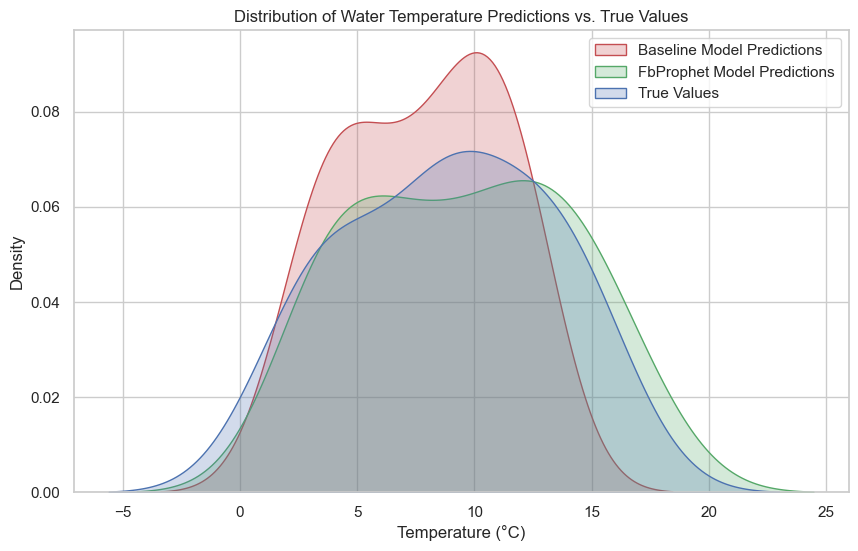

In [47]:
sns.set(style="whitegrid")  # Style for the plot

baseline_predictions = np.round(predictions, 2)
actual_model_predictions = np.round(forecast_water_temp['yhat'], 2)
# Plotting the distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(baseline_predictions, fill=True, color="r", label="Baseline Model Predictions")
sns.kdeplot(actual_model_predictions, fill=True, color="g", label="FbProphet Model Predictions")
sns.kdeplot(test_water_temp['y'], fill=True, color="b", label="True Values")

# Adding labels and title
plt.title('Distribution of Water Temperature Predictions vs. True Values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.legend()

plt.show()

## All Target Variables

### Baseline

In [34]:
target_variables = basisAnalytik.columns[1:]
features = ['time_index', 'Air Temperature', 'Relative Humidity (x100%)', 'Precipitation (mm)', 'Radiation (W/m²)', 'River Discharge (m³/s)']
predictions_dict = {}  # Dictionary to store predictions with key as the target variable name
actual_values_dict = {} # Dictionary to store actual values with key as the target variable name

# Imputer to handle missing values in features
feature_imputer = SimpleImputer(strategy='mean')
# Imputer to handle missing values in target
target_imputer = SimpleImputer(strategy='mean')

# Process each target variable
for target in tqdm(target_variables):
    meteorological_current = meteorological.copy()
    meteorological_current['y'] = basisAnalytik[target]
    meteorological_current = meteorological_current.rename(columns={'Date': 'ds'})

    # Cutoff date for train-test split
    cutoff_date = '2009-01-15'

    train_dataset = meteorological_current[meteorological_current['ds'] < cutoff_date].copy()
    test_dataset = meteorological_current[meteorological_current['ds'] >= cutoff_date].copy()

    # Creating a time index for both training and testing sets
    train_dataset.loc[:, 'time_index'] = range(len(train_dataset))
    test_dataset.loc[:, 'time_index'] = range(len(train_dataset), len(train_dataset) + len(test_dataset))

    X_train = train_dataset[features]
    y_train = train_dataset['y']
    X_test = test_dataset[features]
    y_test = test_dataset['y']

    # Impute missing values in features
    X_train = feature_imputer.fit_transform(X_train)
    X_test = feature_imputer.transform(X_test)

    # Impute missing values in target
    y_train = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test = target_imputer.transform(y_test.values.reshape(-1, 1)).ravel()

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    # Make predictions and store them
    predictions = linear_model.predict(X_test)
    predictions_dict[target] = predictions
    actual_values_dict[target] = y_test

  0%|          | 0/12 [00:00<?, ?it/s]

### FbProphet

In [41]:
target_variables = basisAnalytik.columns[1:]
features = features[1:]  # Adjusting feature list as per your instructions
forecasts_dict = {}

# Process each target variable
for target in tqdm(target_variables):
    meteorological_current = meteorological.copy()
    meteorological_current['y'] = basisAnalytik[target]
    meteorological_current = meteorological_current.rename(columns={'Date': 'ds'})

    cutoff_date = '2009-01-15'
    train = meteorological_current[meteorological_current['ds'] < cutoff_date].reset_index(drop=True)
    test = meteorological_current[meteorological_current['ds'] >= cutoff_date].reset_index(drop=True)
    test_noY = test.drop(columns=['y'])

    # Define the parameter grid
    param_grid = {
        'changepoint_prior_scale': [0.05, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [10.0, 15.0, 20.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

    # Generate all combinations of parameters for the grid
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []

    for params in tqdm(all_params, desc=f"Hyperparameter Tuning for {target}"):
        m = Prophet(**params)
        for feature in features:
            m.add_regressor(feature, standardize=False)
        
        m.fit(train)

        # Adjust initial and horizon if necessary
        initial_days = (train.dropna().shape[0] - 12) * 30
        horizon_days = 365
        while initial_days + horizon_days > train.dropna().shape[0] * 30:
            initial_days -= 30

        df_cv = cross_validation(m, initial=f'{initial_days} days', period='365 days', horizon=f'{horizon_days} days', parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    best_params_idx = np.argmin(rmses)
    best_params = all_params[best_params_idx]

    # Train final model with the best parameters
    final_model = Prophet(interval_width=0.95, **best_params)
    for feature in features:
        final_model.add_regressor(feature, standardize=False)

    final_model.fit(train)
    forecast = final_model.predict(test_noY)
    forecasts_dict[target] = forecast  # Store forecasts with target variable name as key

  0%|          | 0/12 [00:00<?, ?it/s]

Hyperparameter Tuning for Abf._Stoffe_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:29:26 - cmdstanpy - INFO - Chain [1] start processing
16:29:26 - cmdstanpy - INFO - Chain [1] done processing
16:29:28 - cmdstanpy - INFO - Chain [1] start processing
16:29:28 - cmdstanpy - INFO - Chain [1] done processing
16:29:30 - cmdstanpy - INFO - Chain [1] start processing
16:29:30 - cmdstanpy - INFO - Chain [1] done processing
16:29:32 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:34 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1] done processing
16:29:36 - cmdstanpy - INFO - Chain [1] start processing
16:29:36 - cmdstanpy - INFO - Chain [1] done processing
16:29:38 - cmdstanpy - INFO - Chain [1] start processing
16:29:38 - cmdstanpy - INFO - Chain [1] done processing
16:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing
16:29:42 - cmdstanpy - INFO - Chain [1] start processing
16:29:42 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for NH4-N_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing
16:30:36 - cmdstanpy - INFO - Chain [1] start processing
16:30:36 - cmdstanpy - INFO - Chain [1] done processing
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
16:30:40 - cmdstanpy - INFO - Chain [1] start processing
16:30:40 - cmdstanpy - INFO - Chain [1] done processing
16:30:42 - cmdstanpy - INFO - Chain [1] start processing
16:30:42 - cmdstanpy - INFO - Chain [1] done processing
16:30:44 - cmdstanpy - INFO - Chain [1] start processing
16:30:44 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:48 - cmdstanpy - INFO - Chain [1] start processing
16:30:48 - cmdstanpy - INFO - Chain [1] done processing
16:30:50 - cmdstanpy - INFO - Chain [1] start processing
16:30:50 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for BSB5_(EN1899_ohne_ATH)_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:41 - cmdstanpy - INFO - Chain [1] done processing
16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
16:31:54 - cmdstanpy - INFO - Chain [1] start processing
16:31:54 - cmdstanpy - INFO - Chain [1] done processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] done processing
16:31:58 - cmdstanpy - INFO - Chain [1] start processing
16:31:58 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for Chlorid_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:32:54 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
16:33:03 - cmdstanpy - INFO - Chain [1] start processing
16:33:03 - cmdstanpy - INFO - Chain [1] done processing
16:33:05 - cmdstanpy - INFO - Chain [1] start processing
16:33:05 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:10 - cmdstanpy - INFO - Chain [1] done processing
16:33:12 - cmdstanpy - INFO - Chain [1] start processing
16:33:12 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for LF_(20_°C)_vor_Ort_µS/cm:   0%|          | 0/32 [00:00<?, ?it/s]

16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing
16:34:03 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:07 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing
16:34:09 - cmdstanpy - INFO - Chain [1] start processing
16:34:09 - cmdstanpy - INFO - Chain [1] done processing
16:34:11 - cmdstanpy - INFO - Chain [1] start processing
16:34:11 - cmdstanpy - INFO - Chain [1] done processing
16:34:13 - cmdstanpy - INFO - Chain [1] start processing
16:34:13 - cmdstanpy - INFO - Chain [1] done processing
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing
16:34:17 - cmdstanpy - INFO - Chain [1] start processing
16:34:17 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for NO3-N_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] start processing
16:35:12 - cmdstanpy - INFO - Chain [1] done processing
16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:14 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for pH-Wert_(vor_Ort)_-:   0%|          | 0/32 [00:00<?, ?it/s]

16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:11 - cmdstanpy - INFO - Chain [1] done processing
16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:16 - cmdstanpy - INFO - Chain [1] start processing
16:36:16 - cmdstanpy - INFO - Chain [1] done processing
16:36:18 - cmdstanpy - INFO - Chain [1] start processing
16:36:18 - cmdstanpy - INFO - Chain [1] done processing
16:36:20 - cmdstanpy - INFO - Chain [1] start processing
16:36:20 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:22 - cmdstanpy - INFO - Chain [1] done processing
16:36:24 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] done processing
16:36:27 - cmdstanpy - INFO - Chain [1] start processing
16:36:27 - cmdstanpy - INFO - Chain [1] done processing
16:36:29 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for o-PO4-P_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:37:21 - cmdstanpy - INFO - Chain [1] start processing
16:37:21 - cmdstanpy - INFO - Chain [1] done processing
16:37:23 - cmdstanpy - INFO - Chain [1] start processing
16:37:23 - cmdstanpy - INFO - Chain [1] done processing
16:37:25 - cmdstanpy - INFO - Chain [1] start processing
16:37:25 - cmdstanpy - INFO - Chain [1] done processing
16:37:27 - cmdstanpy - INFO - Chain [1] start processing
16:37:28 - cmdstanpy - INFO - Chain [1] done processing
16:37:30 - cmdstanpy - INFO - Chain [1] start processing
16:37:30 - cmdstanpy - INFO - Chain [1] done processing
16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:32 - cmdstanpy - INFO - Chain [1] done processing
16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
16:37:36 - cmdstanpy - INFO - Chain [1] start processing
16:37:36 - cmdstanpy - INFO - Chain [1] done processing
16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:38 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for P-ges._mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:38:31 - cmdstanpy - INFO - Chain [1] start processing
16:38:31 - cmdstanpy - INFO - Chain [1] done processing
16:38:33 - cmdstanpy - INFO - Chain [1] start processing
16:38:33 - cmdstanpy - INFO - Chain [1] done processing
16:38:34 - cmdstanpy - INFO - Chain [1] start processing
16:38:35 - cmdstanpy - INFO - Chain [1] done processing
16:38:36 - cmdstanpy - INFO - Chain [1] start processing
16:38:36 - cmdstanpy - INFO - Chain [1] done processing
16:38:38 - cmdstanpy - INFO - Chain [1] start processing
16:38:38 - cmdstanpy - INFO - Chain [1] done processing
16:38:40 - cmdstanpy - INFO - Chain [1] start processing
16:38:40 - cmdstanpy - INFO - Chain [1] done processing
16:38:42 - cmdstanpy - INFO - Chain [1] start processing
16:38:42 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:44 - cmdstanpy - INFO - Chain [1] done processing
16:38:46 - cmdstanpy - INFO - Chain [1] start processing
16:38:46 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for O2-gelöst_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:39:34 - cmdstanpy - INFO - Chain [1] start processing
16:39:34 - cmdstanpy - INFO - Chain [1] done processing
16:39:36 - cmdstanpy - INFO - Chain [1] start processing
16:39:37 - cmdstanpy - INFO - Chain [1] done processing
16:39:38 - cmdstanpy - INFO - Chain [1] start processing
16:39:39 - cmdstanpy - INFO - Chain [1] done processing
16:39:40 - cmdstanpy - INFO - Chain [1] start processing
16:39:41 - cmdstanpy - INFO - Chain [1] done processing
16:39:43 - cmdstanpy - INFO - Chain [1] start processing
16:39:43 - cmdstanpy - INFO - Chain [1] done processing
16:39:45 - cmdstanpy - INFO - Chain [1] start processing
16:39:45 - cmdstanpy - INFO - Chain [1] done processing
16:39:47 - cmdstanpy - INFO - Chain [1] start processing
16:39:47 - cmdstanpy - INFO - Chain [1] done processing
16:39:49 - cmdstanpy - INFO - Chain [1] start processing
16:39:49 - cmdstanpy - INFO - Chain [1] done processing
16:39:51 - cmdstanpy - INFO - Chain [1] start processing
16:39:51 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for TOC_mg/l:   0%|          | 0/32 [00:00<?, ?it/s]

16:40:41 - cmdstanpy - INFO - Chain [1] start processing
16:40:41 - cmdstanpy - INFO - Chain [1] done processing
16:40:44 - cmdstanpy - INFO - Chain [1] start processing
16:40:44 - cmdstanpy - INFO - Chain [1] done processing
16:40:46 - cmdstanpy - INFO - Chain [1] start processing
16:40:46 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:50 - cmdstanpy - INFO - Chain [1] start processing
16:40:50 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:54 - cmdstanpy - INFO - Chain [1] start processing
16:40:54 - cmdstanpy - INFO - Chain [1] done processing
16:40:56 - cmdstanpy - INFO - Chain [1] start processing
16:40:56 - cmdstanpy - INFO - Chain [1] done processing
16:40:59 - cmdstanpy - INFO - Chain [1] start processing
16:40:59 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning for Wassertemp.(vor_Ort)_°C:   0%|          | 0/32 [00:00<?, ?it/s]

16:41:50 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
16:41:52 - cmdstanpy - INFO - Chain [1] start processing
16:41:52 - cmdstanpy - INFO - Chain [1] done processing
16:41:54 - cmdstanpy - INFO - Chain [1] start processing
16:41:54 - cmdstanpy - INFO - Chain [1] done processing
16:41:56 - cmdstanpy - INFO - Chain [1] start processing
16:41:56 - cmdstanpy - INFO - Chain [1] done processing
16:41:58 - cmdstanpy - INFO - Chain [1] start processing
16:41:58 - cmdstanpy - INFO - Chain [1] done processing
16:42:00 - cmdstanpy - INFO - Chain [1] start processing
16:42:00 - cmdstanpy - INFO - Chain [1] done processing
16:42:02 - cmdstanpy - INFO - Chain [1] start processing
16:42:02 - cmdstanpy - INFO - Chain [1] done processing
16:42:04 - cmdstanpy - INFO - Chain [1] start processing
16:42:04 - cmdstanpy - INFO - Chain [1] done processing
16:42:06 - cmdstanpy - INFO - Chain [1] start processing
16:42:06 - cmdstanpy - INFO - Chain [1]

### Visualize Forecasts

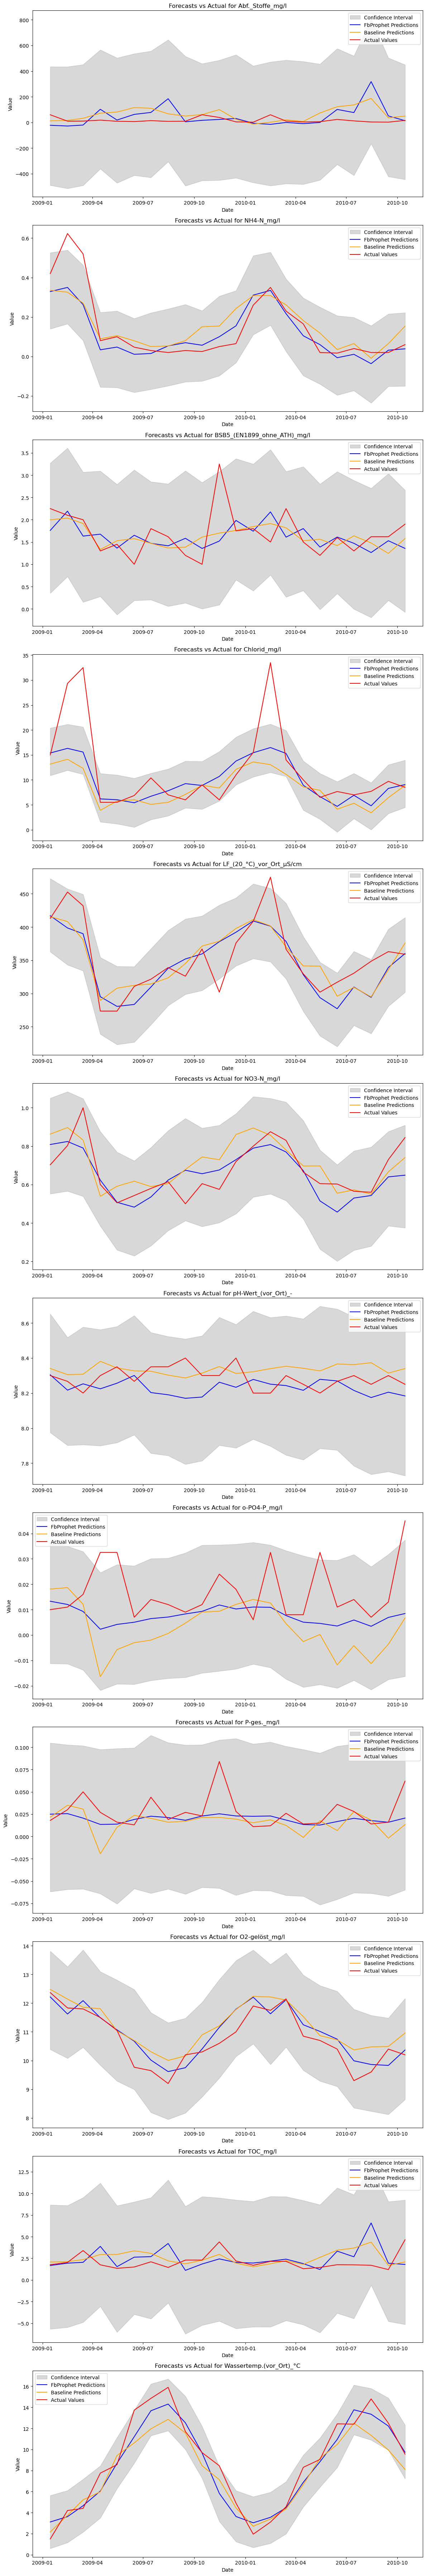

In [42]:
num_targets = len(forecasts_dict)
fig, axes = plt.subplots(num_targets, 1, figsize=(12, 6 * num_targets))  # Adjust size based on number of targets

if num_targets == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one subplot

for ax, target in zip(axes, forecasts_dict.keys()):
    # Extract Prophet model predictions including confidence intervals
    prophet_predictions = forecasts_dict[target]['yhat']
    prophet_lower = forecasts_dict[target]['yhat_lower']
    prophet_upper = forecasts_dict[target]['yhat_upper']

    # Extract baseline predictions and actual values
    baseline_predictions = predictions_dict[target]
    actual_values = actual_values_dict[target]

    # Plotting confidence intervals
    ax.fill_between(next(iter(forecasts_dict.values()))['ds'], prophet_lower, prophet_upper, color='gray', alpha=0.3, label='Confidence Interval')

    # Plotting the predictions and actual values
    ax.plot(next(iter(forecasts_dict.values()))['ds'], prophet_predictions, color='blue', label='FbProphet Predictions')
    ax.plot(next(iter(forecasts_dict.values()))['ds'], baseline_predictions, color='orange', label='Baseline Predictions')
    ax.plot(next(iter(forecasts_dict.values()))['ds'], actual_values, color='red', label='Actual Values')

    # Set titles and labels
    ax.set_title(f'Forecasts vs Actual for {target}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Predictions look good for the two main candidate target variables "Wasser Temperatur" & 'O2- gelost'

### Scores

In [44]:
metrics_columns = ['Target Variable', 'MAE Prophet', 'MSE Prophet', 'MAPE Prophet',
                   'MAE Baseline', 'MSE Baseline', 'MAPE Baseline']
metrics_df = pd.DataFrame(columns=metrics_columns)

# Iterate through each target variable
for target in forecasts_dict.keys():
    # Extract predicted and actual values for Prophet
    predicted_values_prophet = forecasts_dict[target]['yhat']
    actual_values = actual_values_dict[target]

    # Extract predicted values for Baseline
    predicted_values_baseline = predictions_dict[target]

    # Calculate metrics for Prophet
    mae_prophet = mean_absolute_error(actual_values, predicted_values_prophet)
    mse_prophet = mean_squared_error(actual_values, predicted_values_prophet)
    mape_prophet = mean_absolute_percentage_error(actual_values, predicted_values_prophet)

    # Calculate metrics for Baseline
    mae_baseline = mean_absolute_error(actual_values, predicted_values_baseline)
    mse_baseline = mean_squared_error(actual_values, predicted_values_baseline)
    mape_baseline = mean_absolute_percentage_error(actual_values, predicted_values_baseline)

    # Prepare a dictionary to hold metrics
    new_row = pd.DataFrame({
        'Target Variable': [target],
        'MAE Prophet': [mae_prophet],
        'MSE Prophet': [mse_prophet],
        'MAPE Prophet': [mape_prophet],
        'MAE Baseline': [mae_baseline],
        'MSE Baseline': [mse_baseline],
        'MAPE Baseline': [mape_baseline]
    })

    # Append the new row to the DataFrame
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

C:\Users\david\AppData\Local\Temp\ipykernel_21688\3131268520.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


In [45]:
metrics_df

,Target Variable,MAE Prophet,MSE Prophet,MAPE Prophet,MAE Baseline,MSE Baseline,MAPE Baseline
0,Abf._Stoffe_mg/l,56.977936,7978.364207,848.563760,55.464616,5054.899184,732.450435
1,NH4-N_mg/l,0.060830,0.008333,85.072997,0.074483,0.011323,128.686373
2,BSB5_(EN1899_ohne_ATH)_mg/l,0.378767,0.267240,22.363303,0.302706,0.195123,18.638782
3,Chlorid_mg/l,3.448096,37.524925,23.654951,4.208631,52.816759,27.600660
4,LF_(20_°C)_vor_Ort_µS/cm,24.089122,1093.557960,6.756962,25.697946,1132.949256,7.298401
5,NO3-N_mg/l,0.069657,0.008690,10.311900,0.081649,0.009690,12.396352
6,pH-Wert_(vor_Ort)_-,0.081697,0.009589,0.982913,0.072579,0.006831,0.877629
7,o-PO4-P_mg/l,0.010322,0.000221,49.676876,0.016392,0.000424,101.930603
8,P-ges._mg/l,0.011992,0.000347,37.428313,0.015590,0.000520,52.723994
9,O2-gelöst_mg/l,0.339998,0.173442,3.284976,0.456037,0.314616,4.453313


### Distributions Predicted & Actual

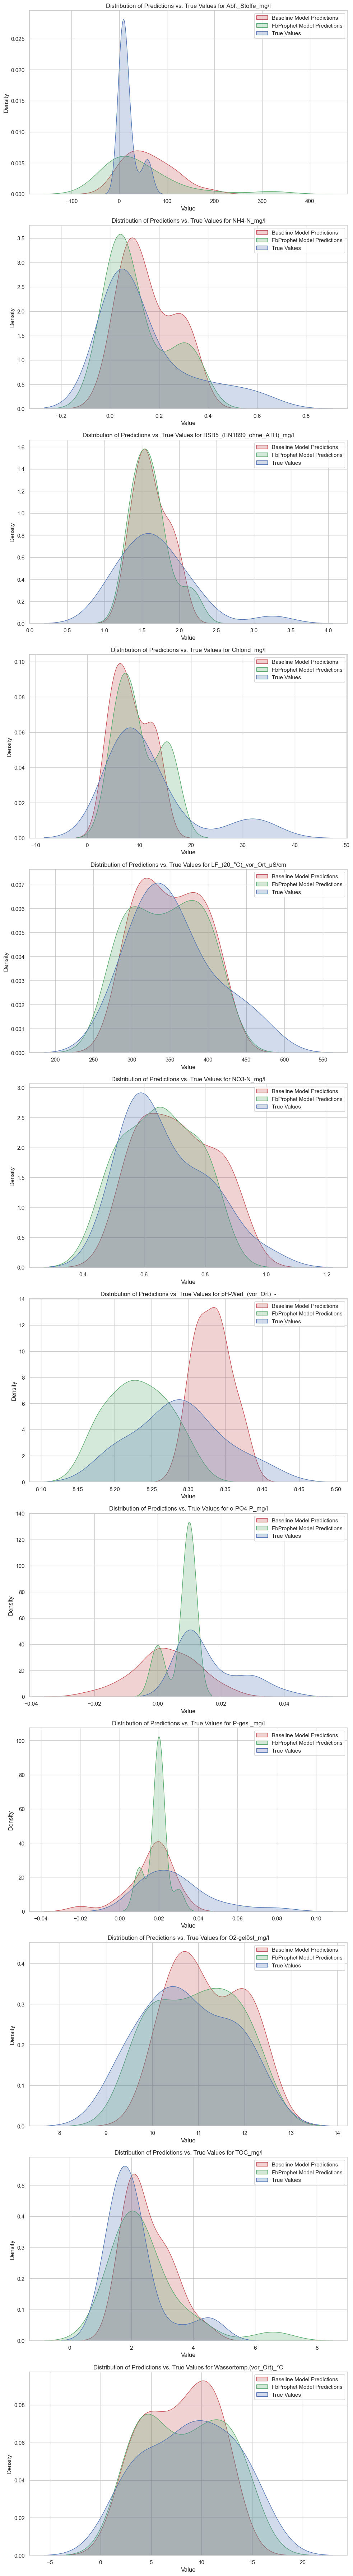

In [43]:
# Set the style for all plots
sns.set(style="whitegrid")

num_targets = len(forecasts_dict)
fig, axes = plt.subplots(num_targets, 1, figsize=(10, 6 * num_targets))  # Adjust size as needed

if num_targets == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one subplot

for ax, target in zip(axes, forecasts_dict.keys()):
    # Extracting data for the current target
    baseline_predictions = np.round(predictions_dict[target], 2)  # Assuming predictions are direct arrays
    actual_model_predictions = np.round(forecasts_dict[target]['yhat'], 2)
    true_values = np.round(actual_values_dict[target], 2)  # Assuming true values are direct arrays

    # Plotting the distributions
    sns.kdeplot(baseline_predictions, fill=True, color="r", label="Baseline Model Predictions", ax=ax)
    sns.kdeplot(actual_model_predictions, fill=True, color="g", label="FbProphet Model Predictions", ax=ax)
    sns.kdeplot(true_values, fill=True, color="b", label="True Values", ax=ax)

    # Adding labels and title
    ax.set_title(f'Distribution of Predictions vs. True Values for {target}')
    ax.set_xlabel('Value')  # General label for any variable type
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()